In [1]:
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import backend as K

import matplotlib.pyplot as plt
import numpy as np

from sklearn.preprocessing import maxabs_scale, minmax_scale
from sklearn.metrics import classification_report, confusion_matrix

from scipy import signal

import librosa
import librosa.display

import os
import os.path as path
os.environ['CUDA_VISIBLE_DEVICES'] = '6,7'

In [2]:
base_dir = path.join('..', 'data')
data_dir = path.join(base_dir, 'data_speech_commands_v0.02')
 
train_txt = path.join(data_dir, 'wav_train_16words.txt')
val_txt = path.join(data_dir, 'wav_validation_16words.txt')
test_txt = path.join(data_dir, 'wav_test_16words.txt')

train_data = np.load(path.join(data_dir, 'wav_train_data.npz'))
val_data = np.load(path.join(data_dir, 'wav_validation_data.npz'))
test_data = np.load(path.join(data_dir, 'wav_test_data.npz'))

In [3]:
x_train = train_data['x_train']
y_train = train_data['y_train']
x_val = val_data['x_val']
y_val = val_data['y_val']
x_test = test_data['x_test']
y_test = test_data['y_test']
y_table = test_data['table']

x_train.shape, y_train.shape, x_val.shape, y_val.shape, x_test.shape, y_test.shape, y_table.shape

((36805, 16000, 1),
 (36805,),
 (4293, 16000, 1),
 (4293,),
 (4815, 16000, 1),
 (4815,),
 (16, 2))

In [4]:
input_shape = x_test[0].shape
output_size = y_table.shape[0]

In [5]:
x_train_abs = np.asarray([maxabs_scale(wav) for wav in x_train])
y_train_onehot = np.asarray([to_categorical(label, output_size) for label in y_train])
del x_train, y_train

x_val_abs = np.asarray([maxabs_scale(wav) for wav in x_val])
y_val_onehot = np.asarray([to_categorical(label, output_size) for label in y_val])
del x_val, y_val

x_test_abs = np.asarray([maxabs_scale(wav) for wav in x_test])
y_test_onehot = np.asarray([to_categorical(label, output_size) for label in y_test])
del x_test, y_test

In [6]:
log_dir = 'log'
os.makedirs(log_dir, exist_ok=True)
base = '1D_CNN_custom_ch_32_DO_075_DO'

i = 8
model_name = base+'_{}_conv'.format(i)
print()
print(model_name, 'Model')
model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
model_filename = model_path + sorted(os.listdir(model_path))[-1]

model = load_model(model_filename)
model.summary()

[loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
print('Loss:', loss, 'Accuracy:', accuracy)

# del(model)


1D_CNN_custom_ch_32_DO_075_DO_8_conv Model
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_67 (Conv1D)           (None, 16000, 32)         192       
_________________________________________________________________
activation_67 (Activation)   (None, 16000, 32)         0         
_________________________________________________________________
conv1d_68 (Conv1D)           (None, 16000, 32)         5152      
_________________________________________________________________
activation_68 (Activation)   (None, 16000, 32)         0         
_________________________________________________________________
max_pooling1d_55 (MaxPooling (None, 5333, 32)          0     

---

In [7]:
def get_activation_maximization(model, layer_index, filter_index):
    activations_list = [layer for layer in model.layers
                                   if layer.name.find('activation') >= 0]
    
    # build a loss function that maximizes the activation
    # of the nth filter of the layer considered
    layer_output = activations_list[layer_index].output
    loss = K.mean(layer_output[:, :, filter_index])

    # compute the gradient of the input picture wrt this loss
    grads = K.gradients(loss, model.input)[0]

    # normalization trick: we normalize the gradient
    grads /= (K.sqrt(K.mean(K.square(grads))) + K.epsilon())

    # this function returns the loss and grads given the input picture
    iterate = K.function([model.input], [loss, grads])
    
    output_dim=16000
    if K.image_data_format() == 'channels_first':
        input_audio_data = np.random.random(
            (1, 1, output_dim))
    else:
        input_audio_data = np.random.random(
            (1, output_dim, 1))
    input_audio_data = (input_audio_data - 0.5) * 20 + 128
    
    step=1
    epochs=100
    
    # we start from a gray image with some noise
    # input_img_data = np.random.random((1, 3, 224, 224)) * 20 + 128.
    for i in range(epochs):
        loss_value, grads_value = iterate([input_audio_data])
        
#         print(i)
#         plt.figure()
#         plt.plot(input_audio_data.squeeze(), label='input_random_noise')
#         plt.plot(grads_value.squeeze(), label='gradient_value')
#         plt.legend()
#         plt.show()
        
        input_audio_data += grads_value * step
#         print(loss_value)

    return input_audio_data

In [8]:
def deprocess_wav(x):
    # normalize tensor: center on 0., ensure std is 0.1
    x -= x.mean()
    x /= (x.std() + 1e-5)
    x *= 0.1
    x = np.clip(x, -1, 1)
    return x

0


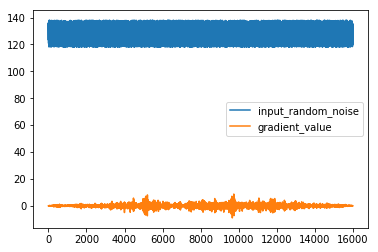

1


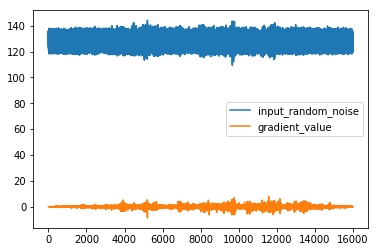

2


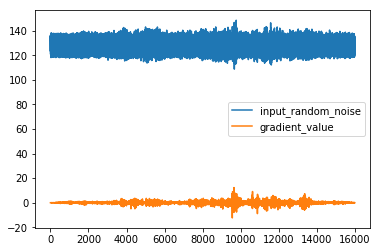

3


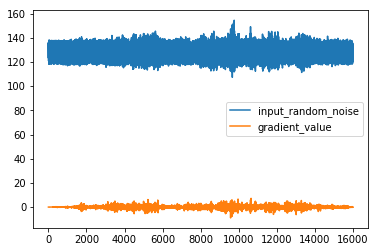

4


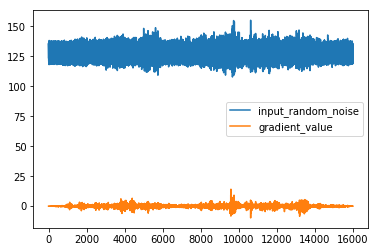

5


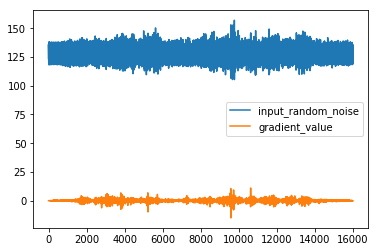

6


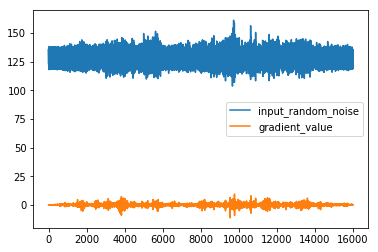

7


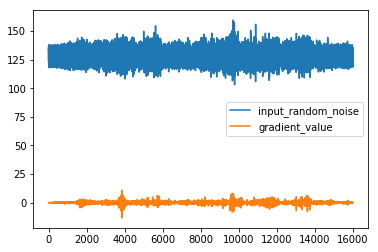

8


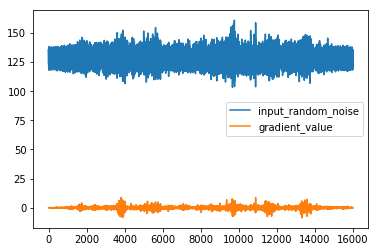

9


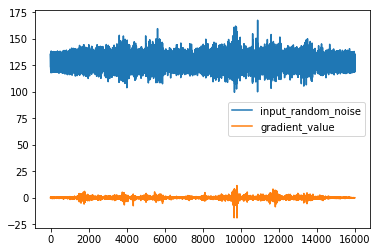

10


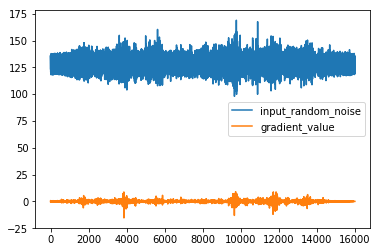

11


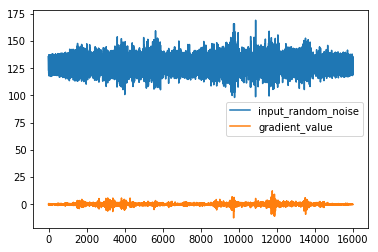

12


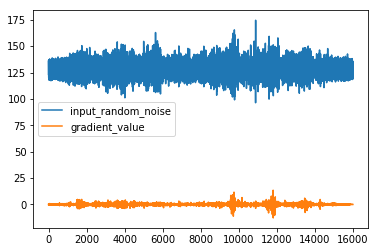

13


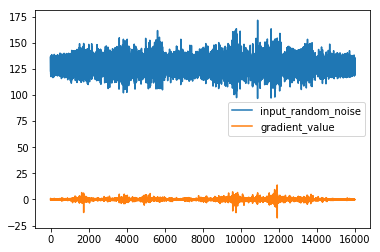

14


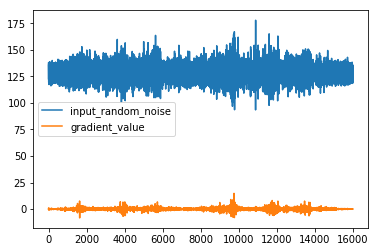

15


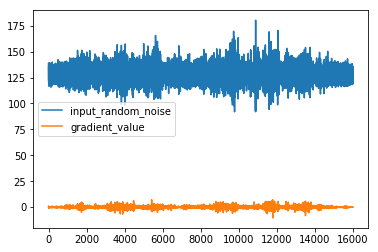

16


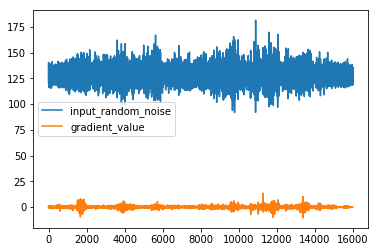

17


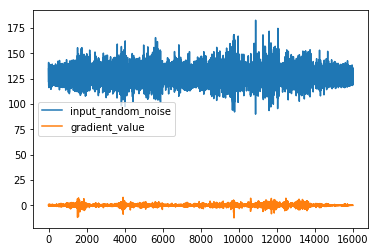

18


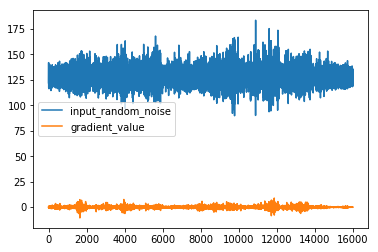

19


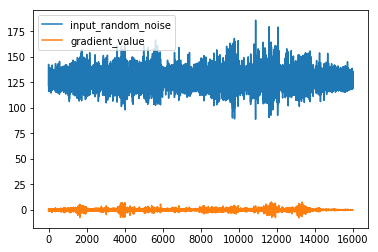

20


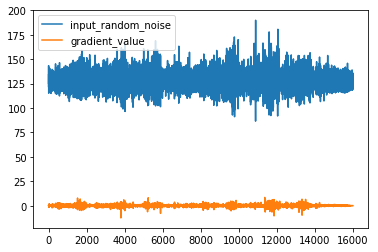

21


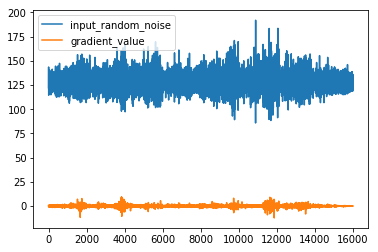

22


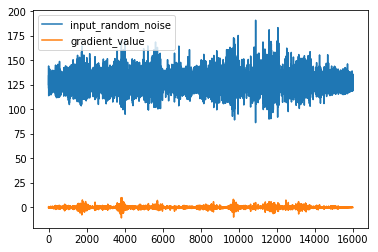

23


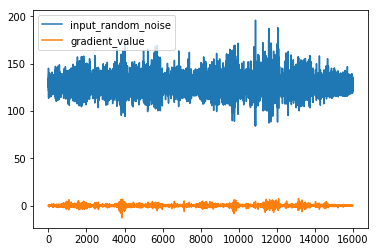

24


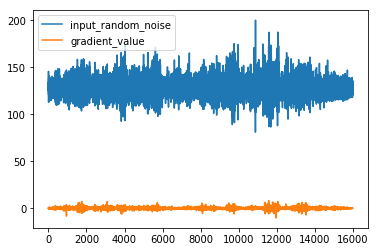

25


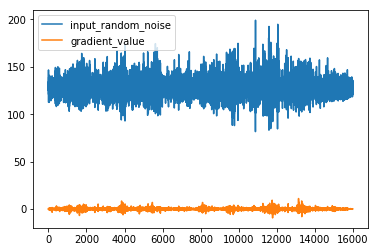

26


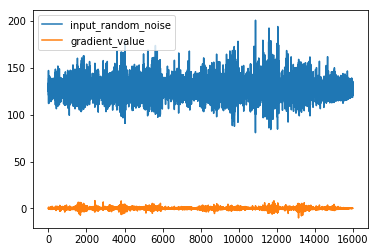

27


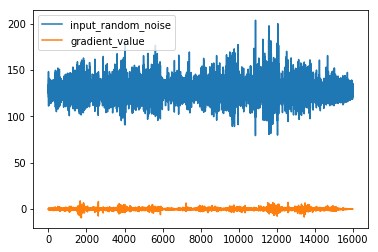

28


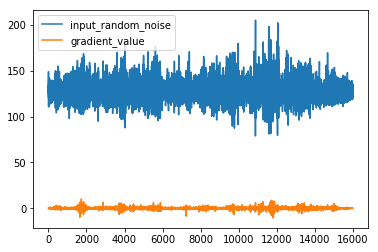

29


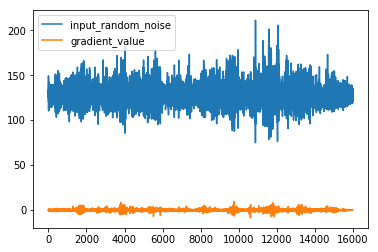

30


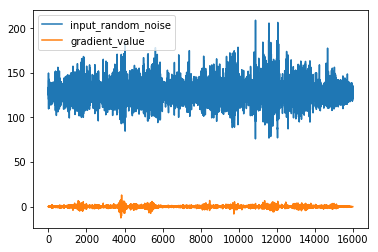

31


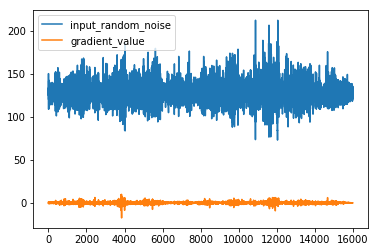

32


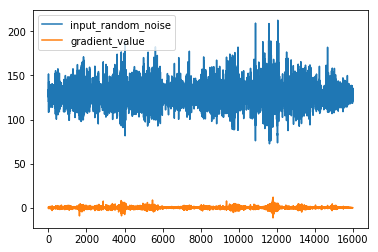

33


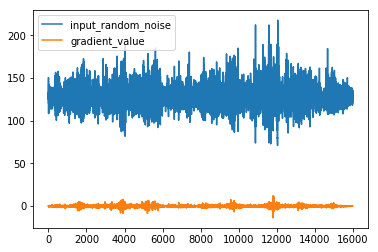

34


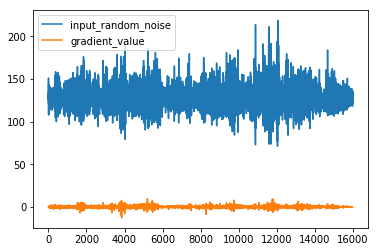

35


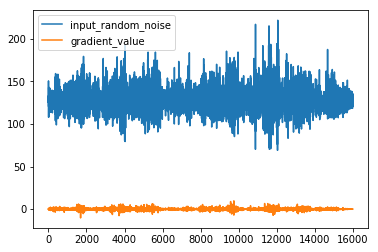

36


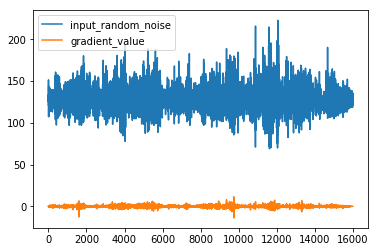

37


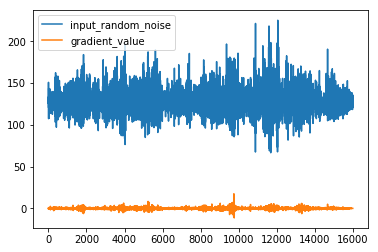

38


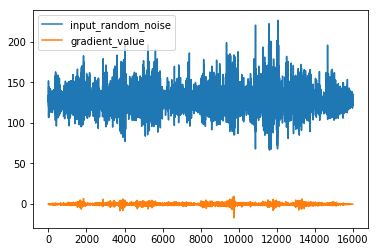

39


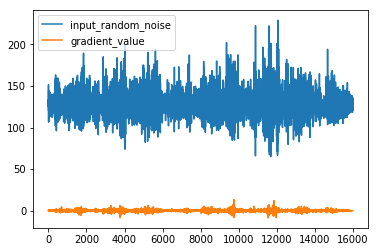

40


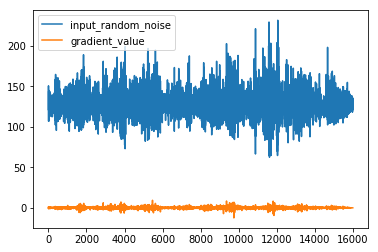

41


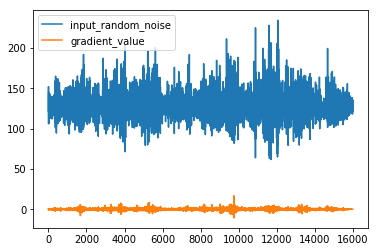

42


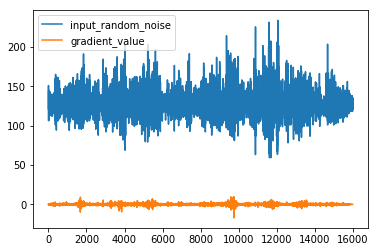

43


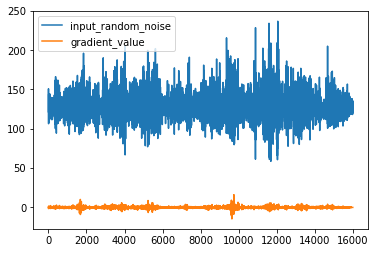

44


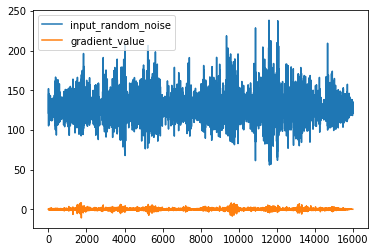

45


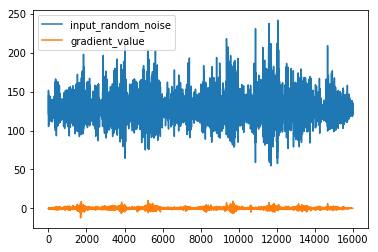

46


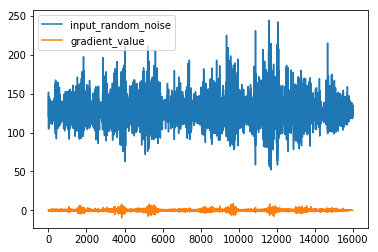

47


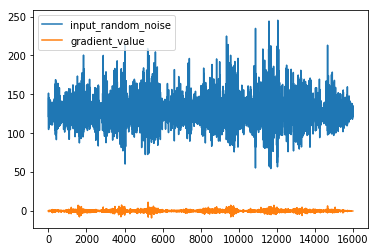

48


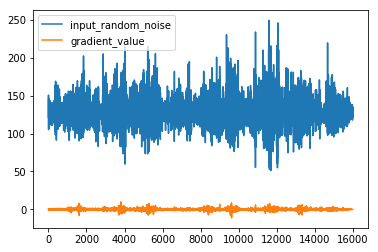

49


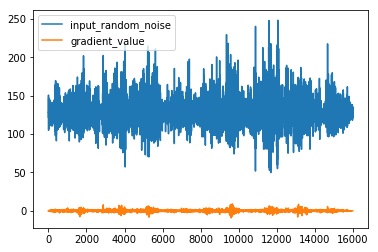

50


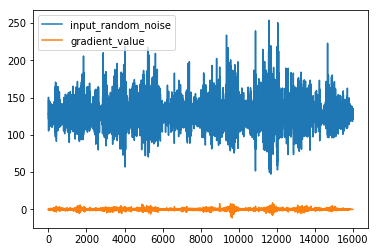

51


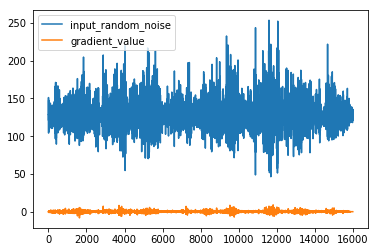

52


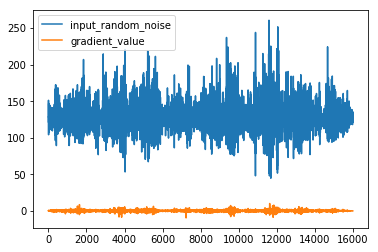

53


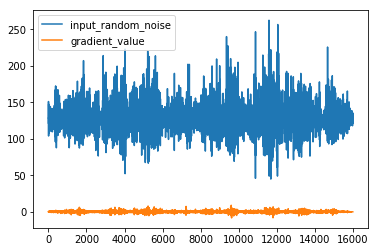

54


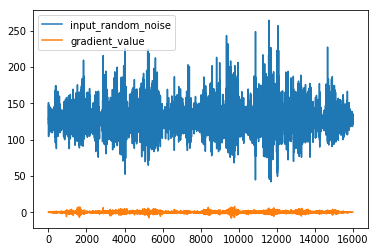

55


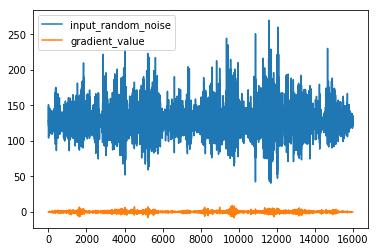

56


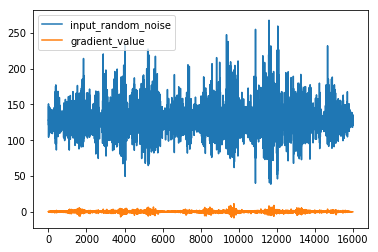

57


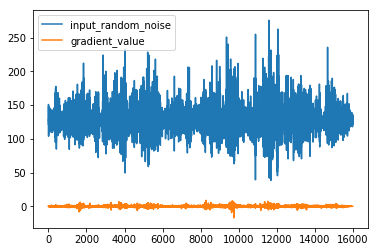

58


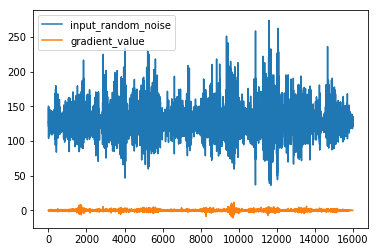

59


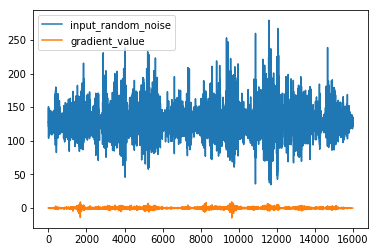

60


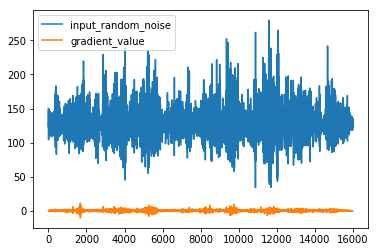

61


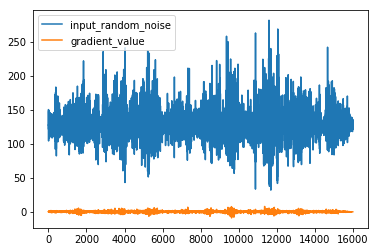

62


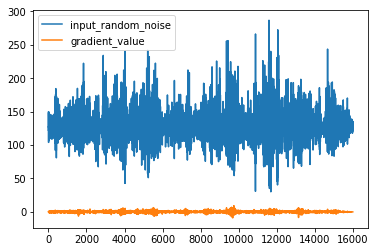

63


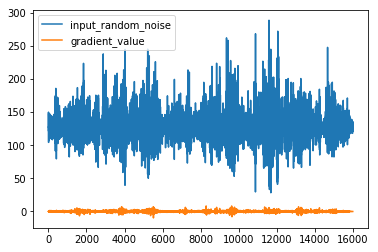

64


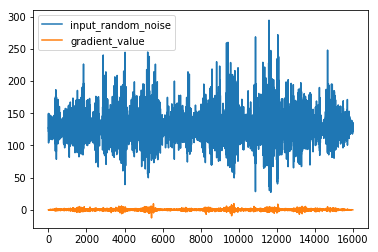

65


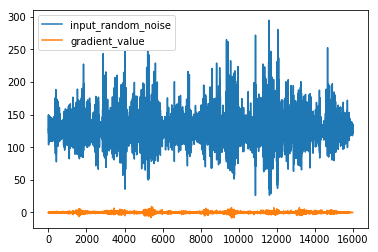

66


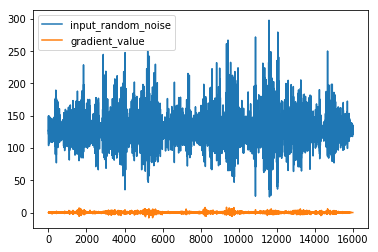

67


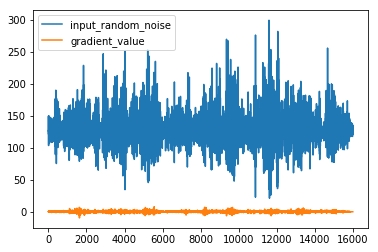

68


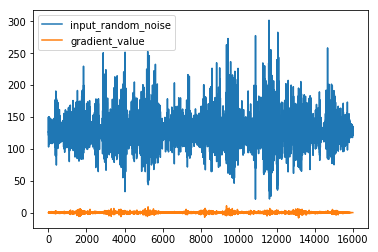

69


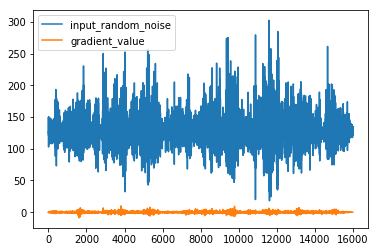

70


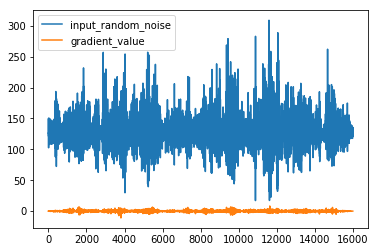

71


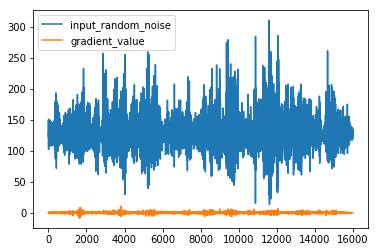

72


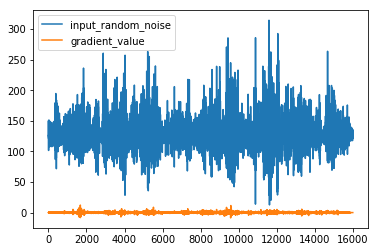

73


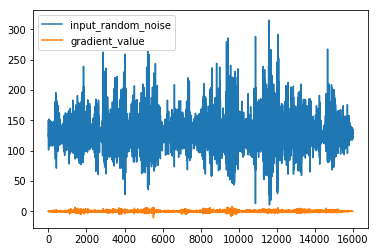

74


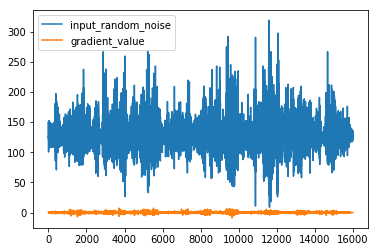

75


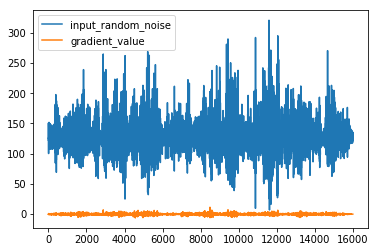

76


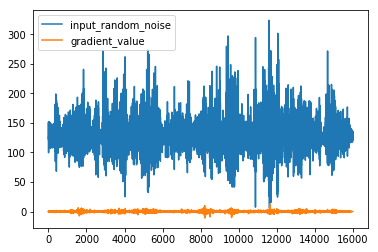

77


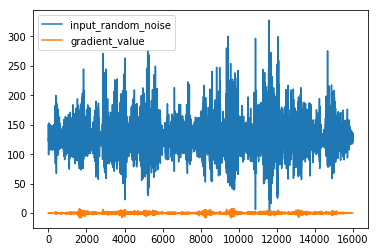

78


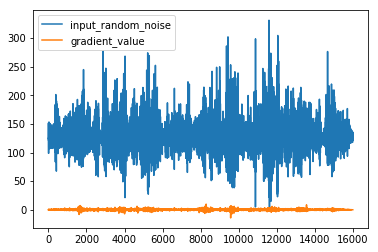

79


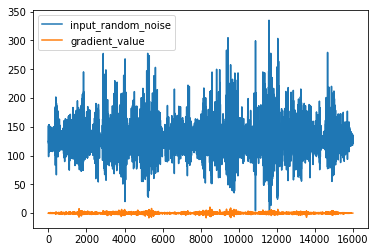

80


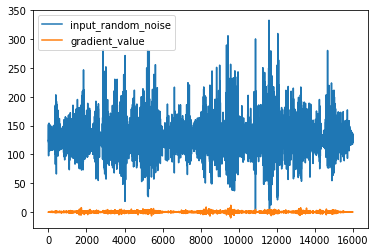

81


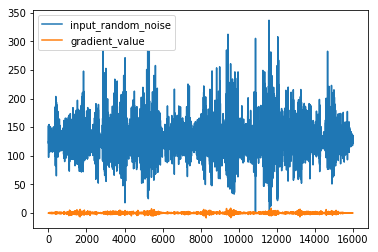

82


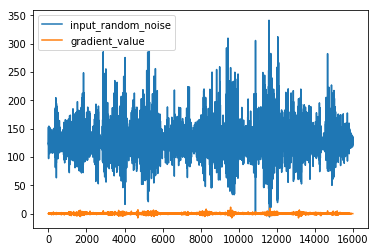

83


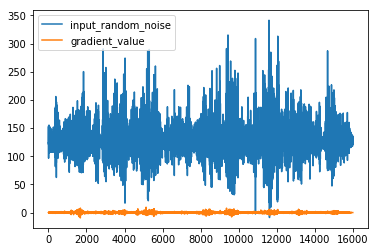

84


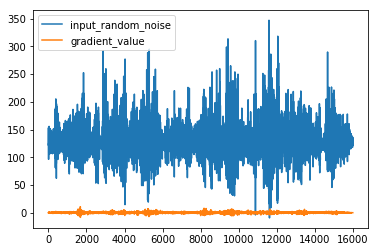

85


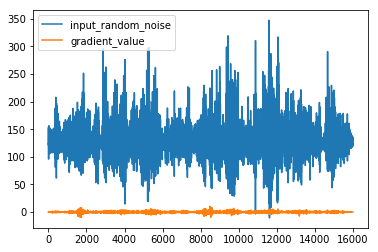

86


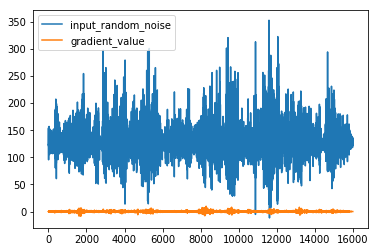

87


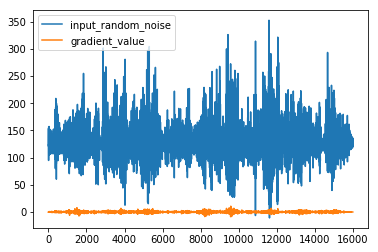

88


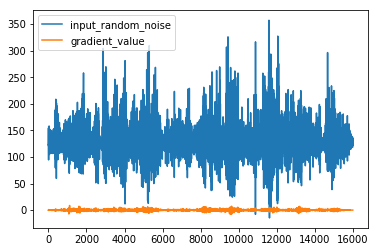

89


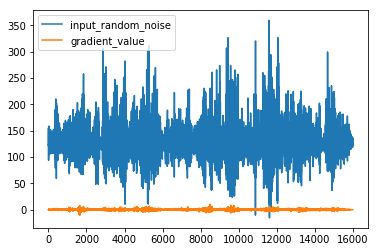

90


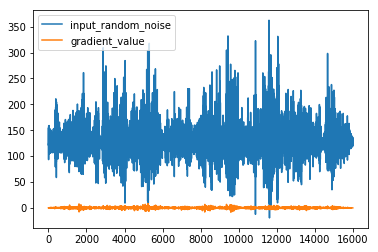

91


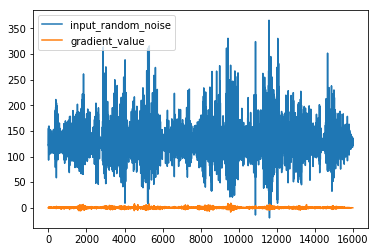

92


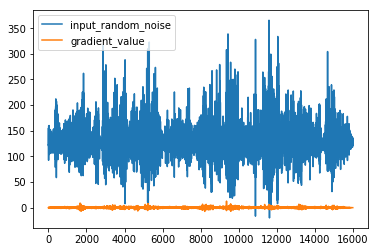

93


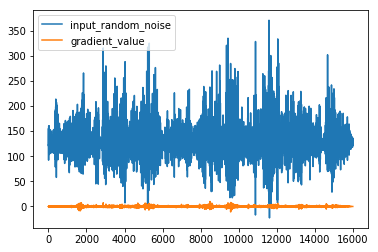

94


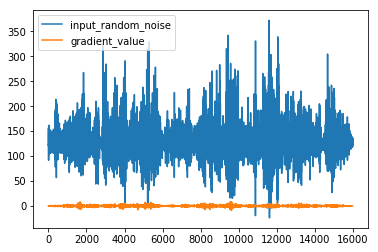

95


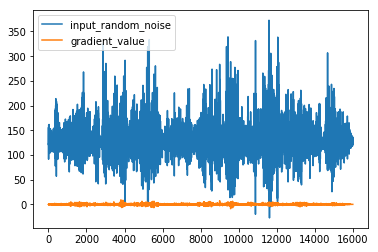

96


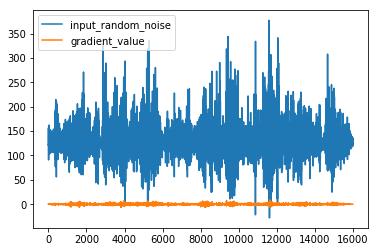

97


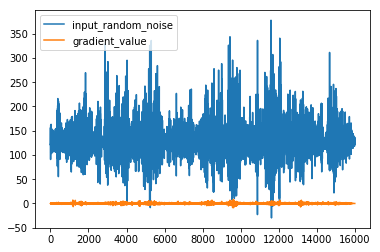

98


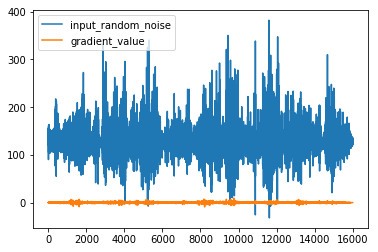

99


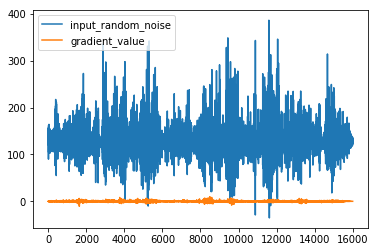

In [174]:
result = get_activation_maximization(model, 7, 0)

0


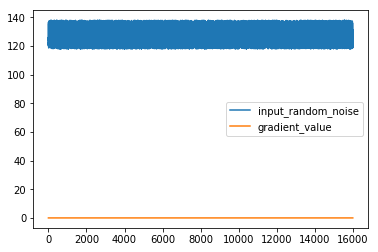

1


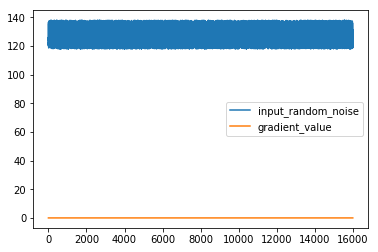

2


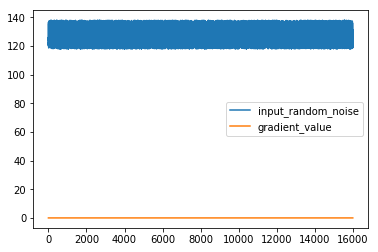

3


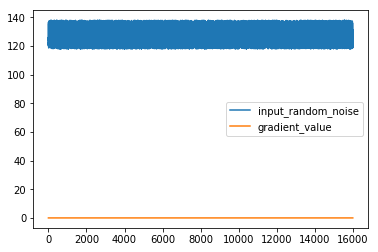

4


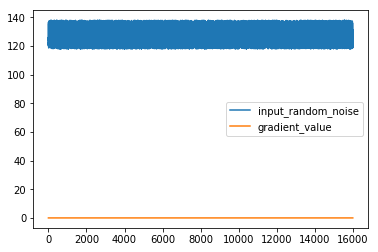

5


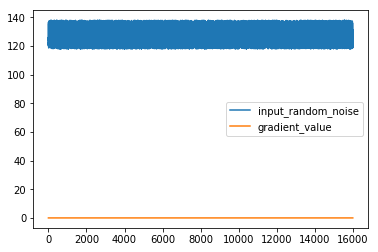

6


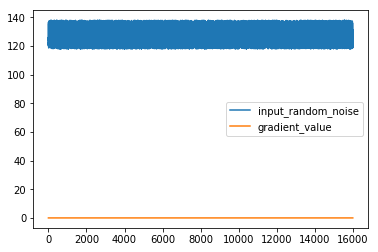

7


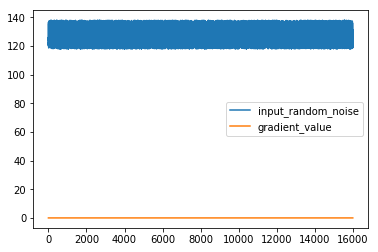

8


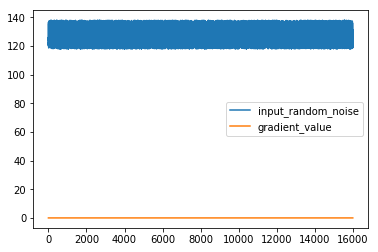

9


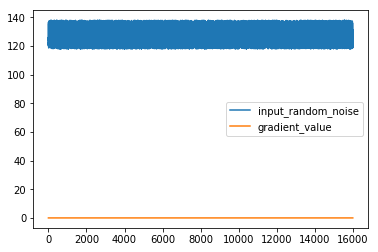

10


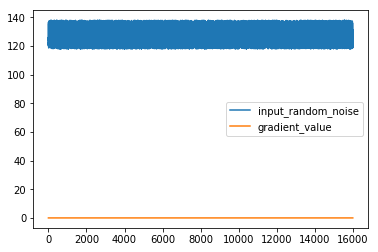

11


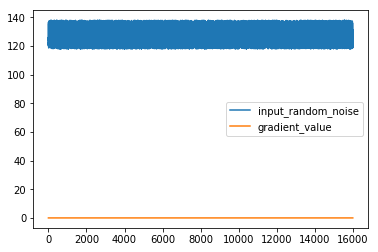

12


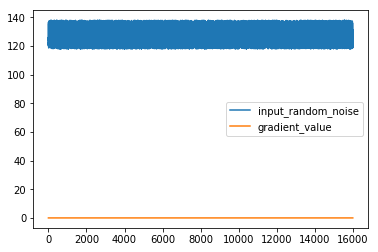

13


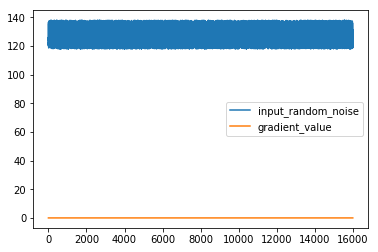

14


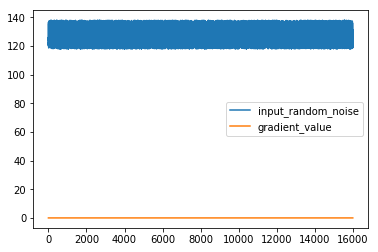

15


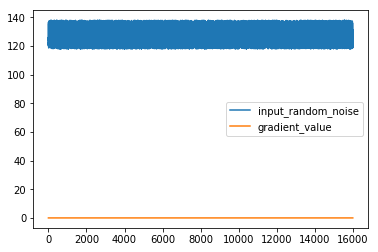

16


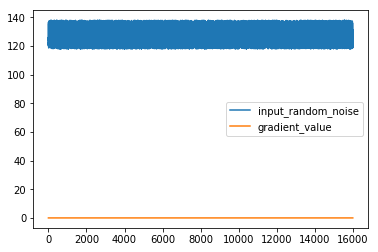

17


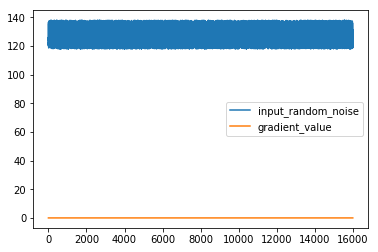

18


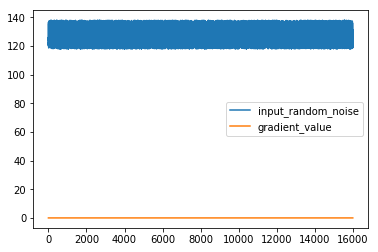

19


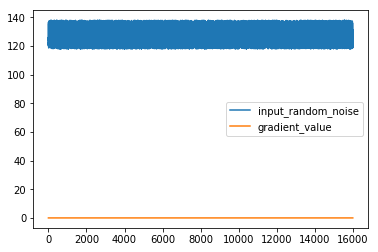

20


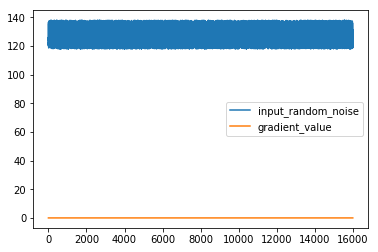

21


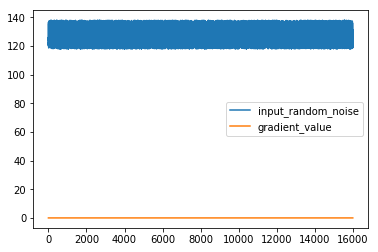

22


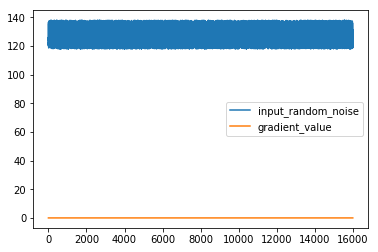

23


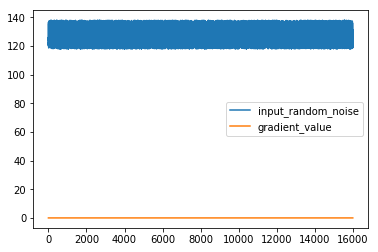

24


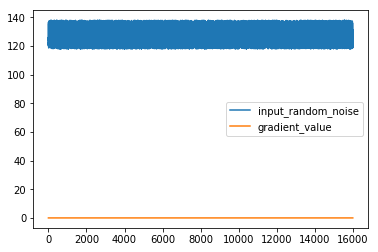

25


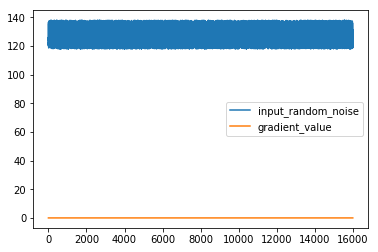

26


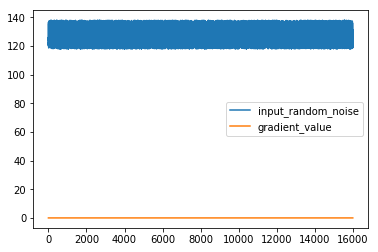

27


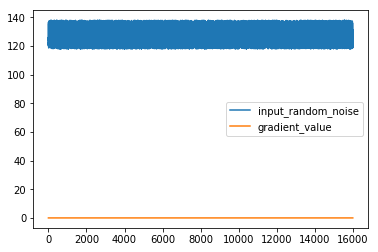

28


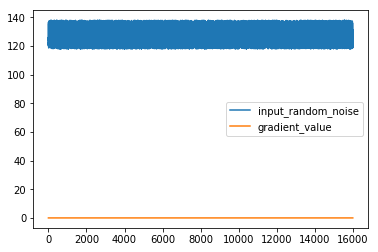

29


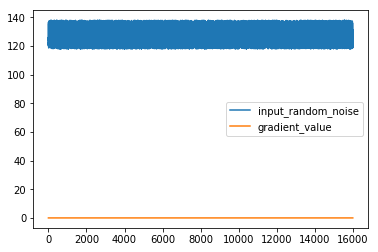

30


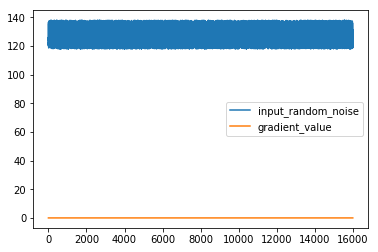

31


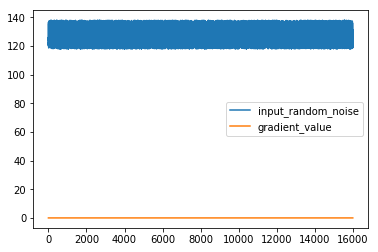

32


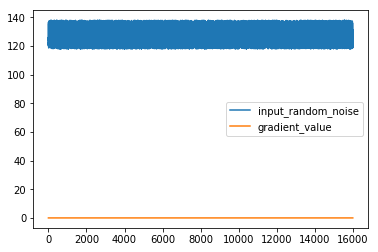

33


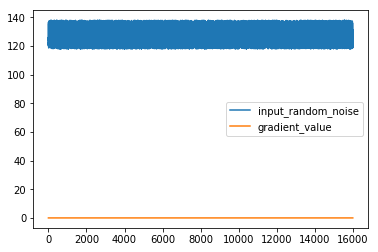

34


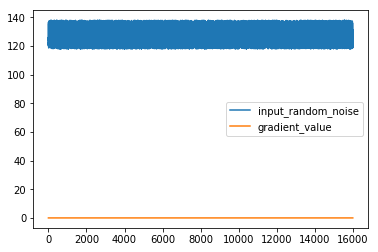

35


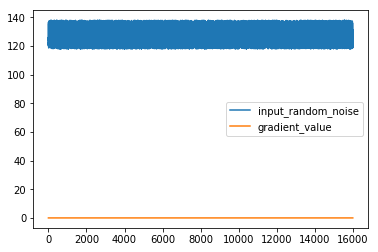

36


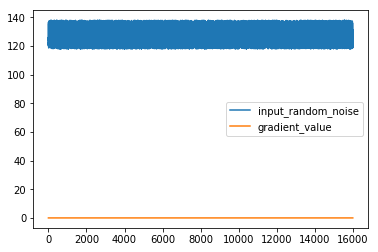

37


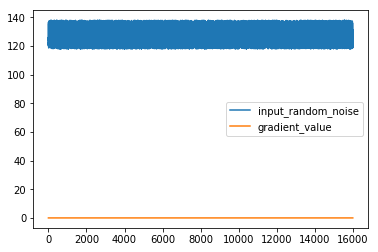

38


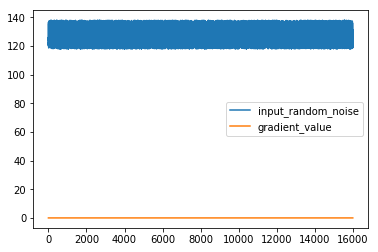

39


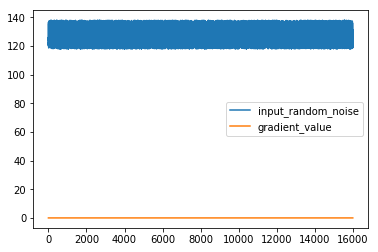

40


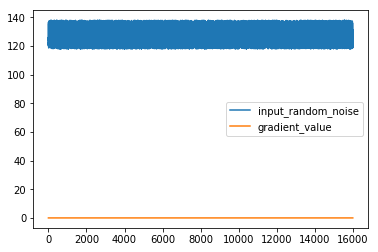

41


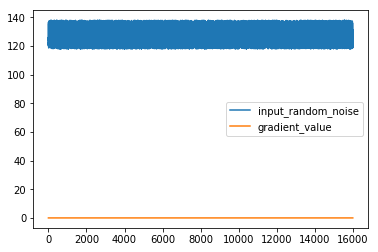

42


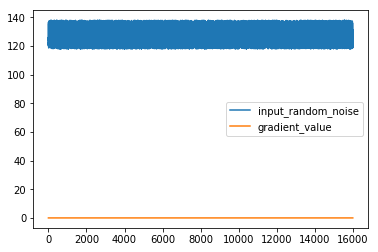

43


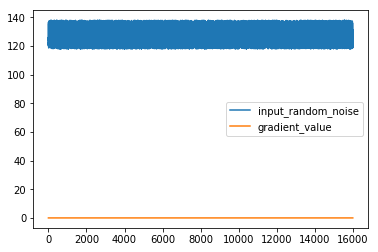

44


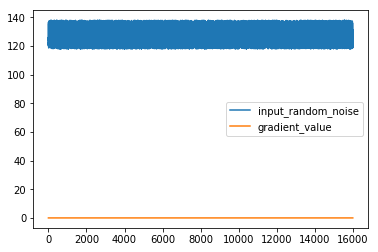

45


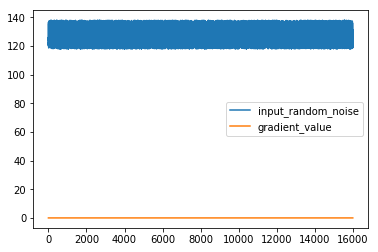

46


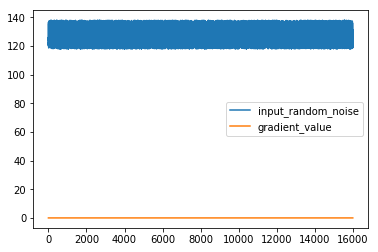

47


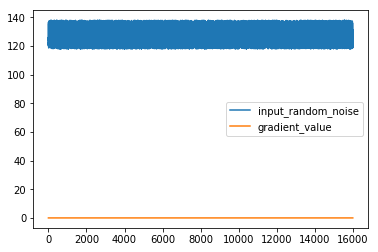

48


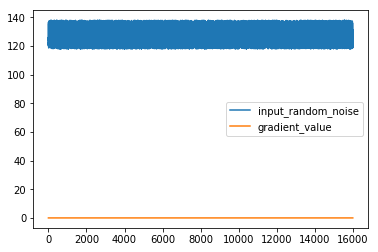

49


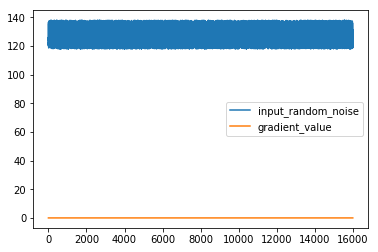

50


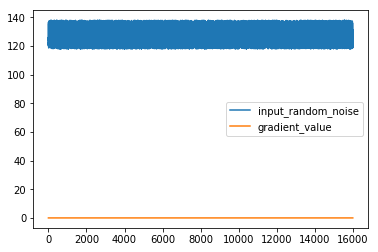

51


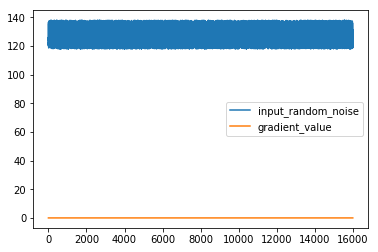

52


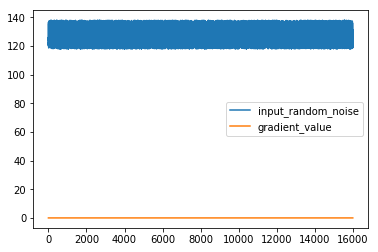

53


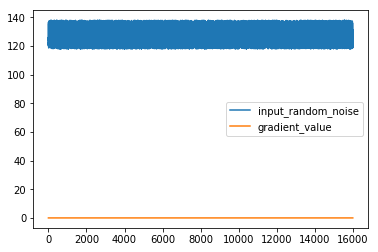

54


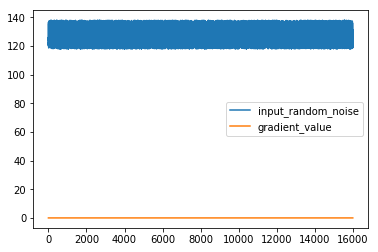

55


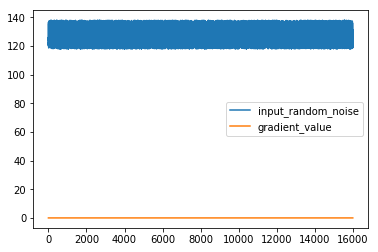

56


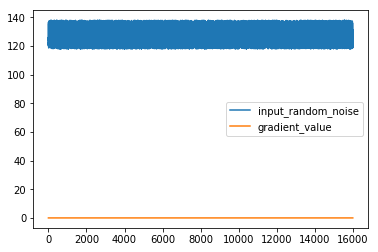

57


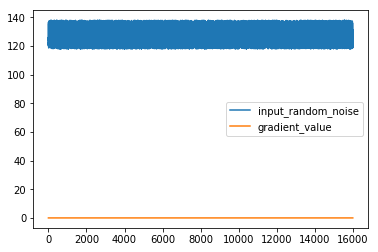

58


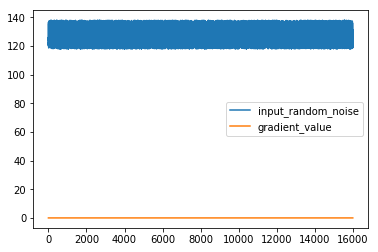

59


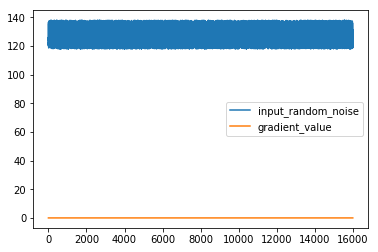

60


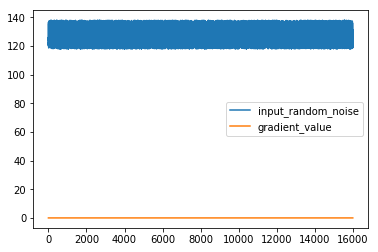

61


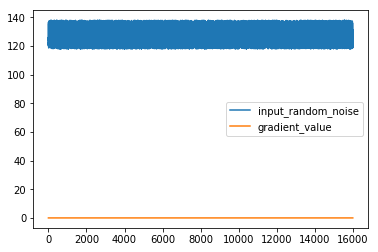

62


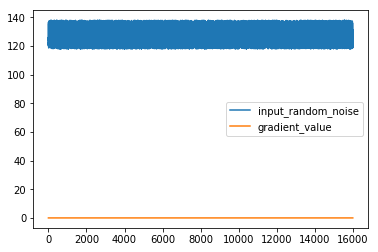

63


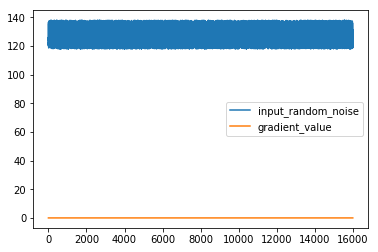

64


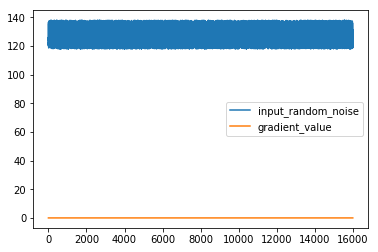

65


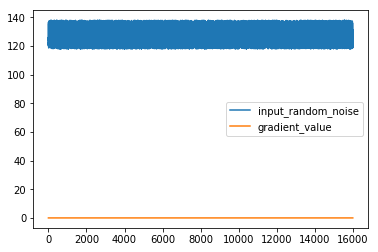

66


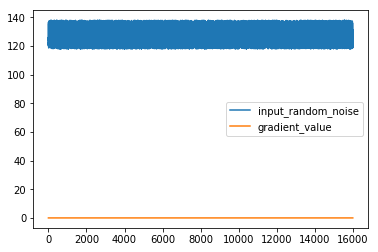

67


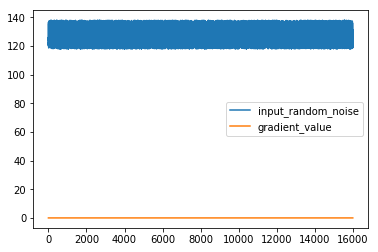

68


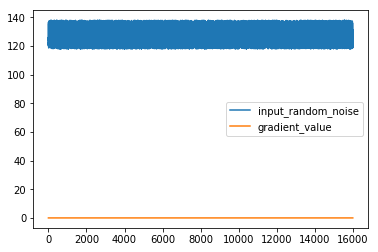

69


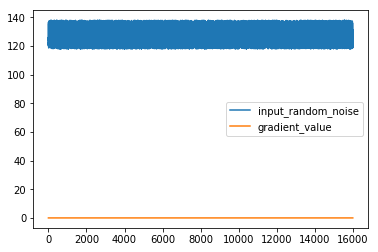

70


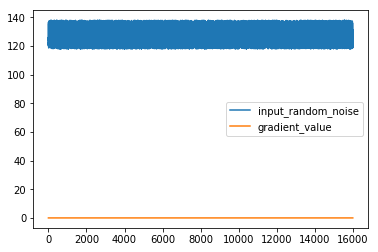

71


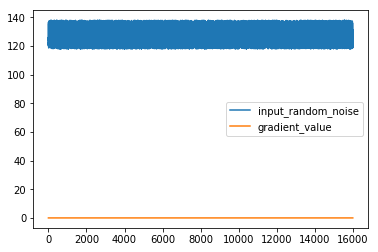

72


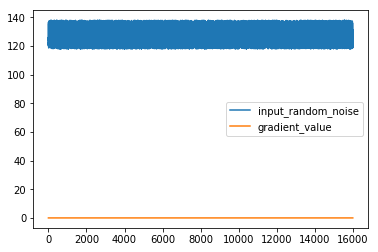

73


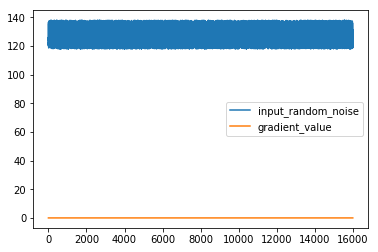

74


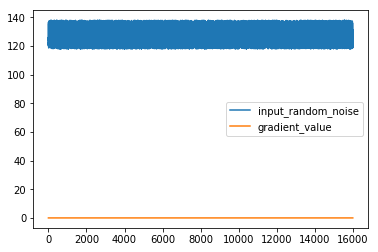

75


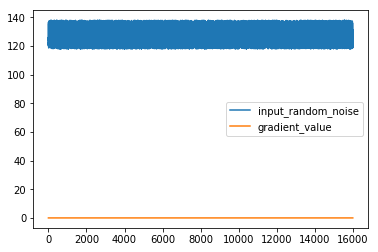

76


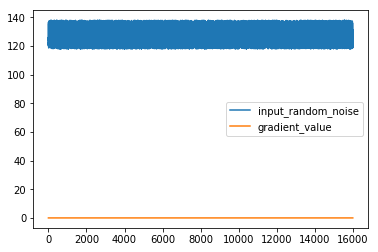

77


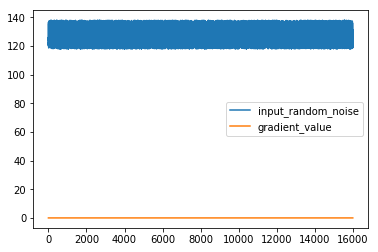

78


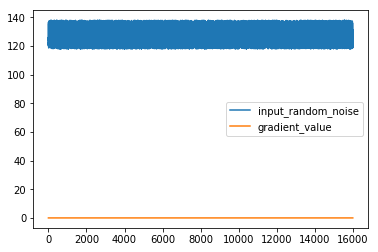

79


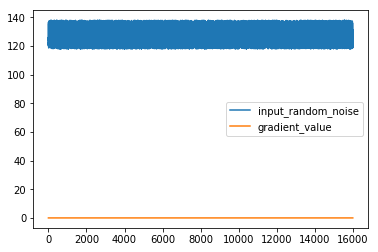

80


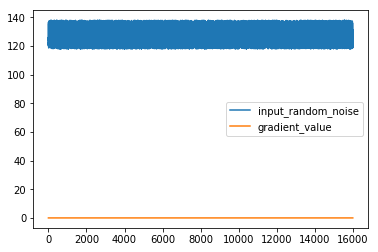

81


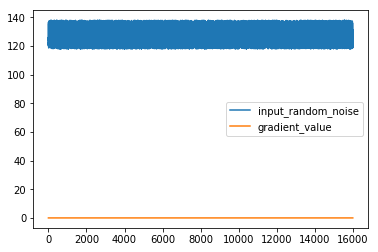

82


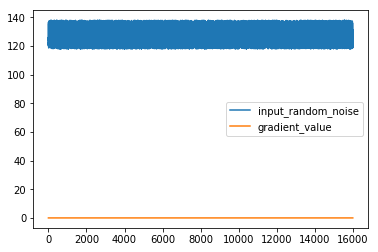

83


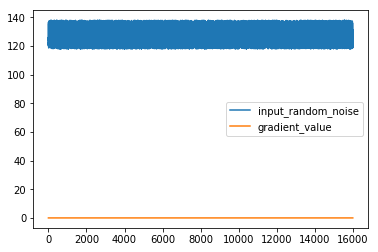

84


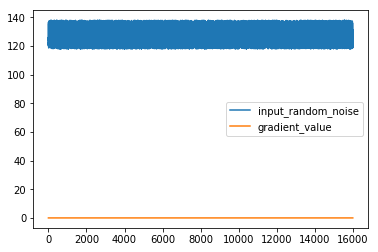

85


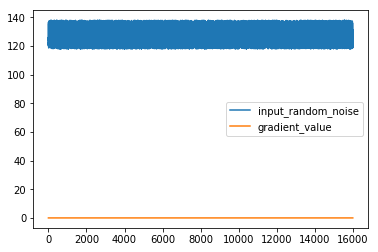

86


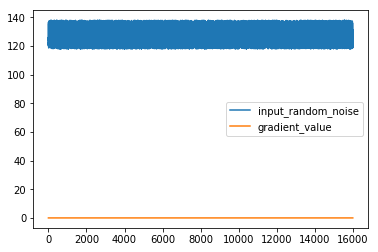

87


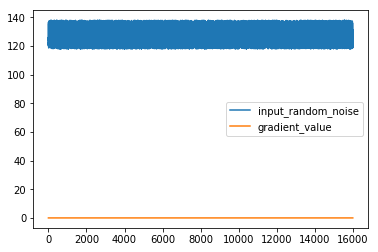

88


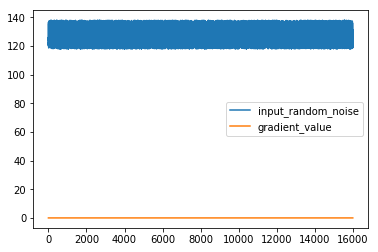

89


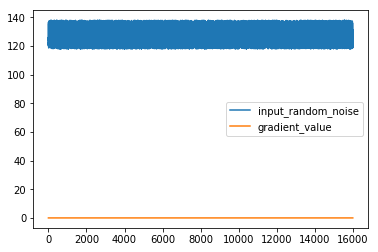

90


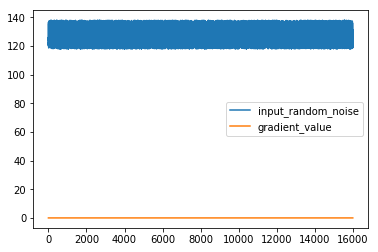

91


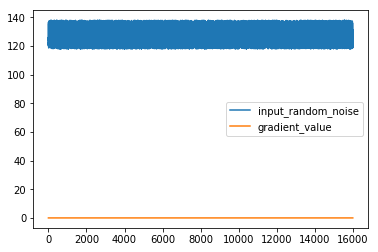

92


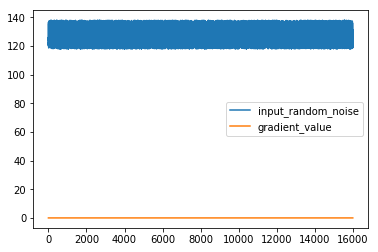

93


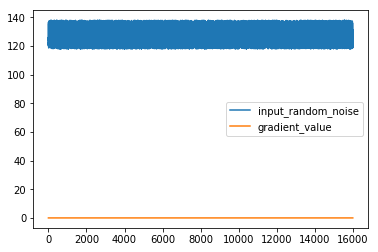

94


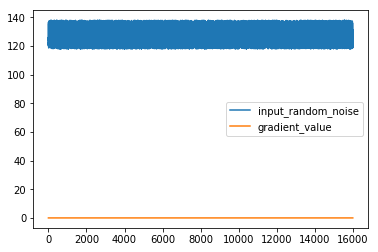

95


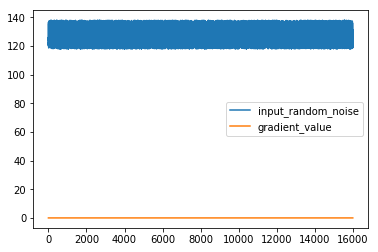

96


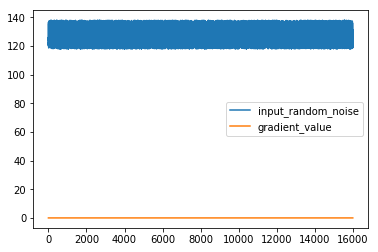

97


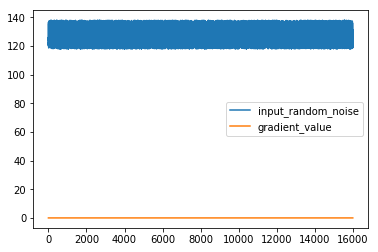

98


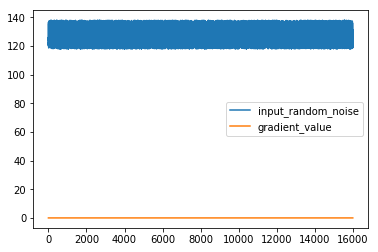

99


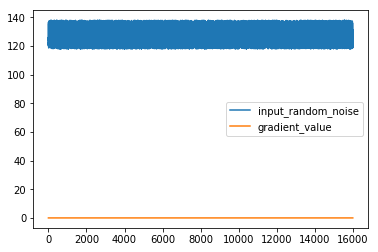

In [175]:
result = get_activation_maximization(model, 7, 1)

In [101]:
result.max()

457.57926472758646

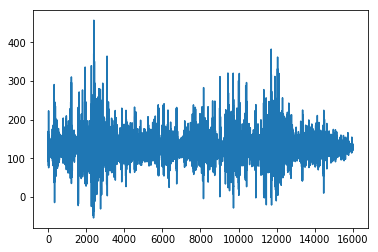

In [102]:
plt.figure()
plt.plot(result.squeeze())
plt.show()

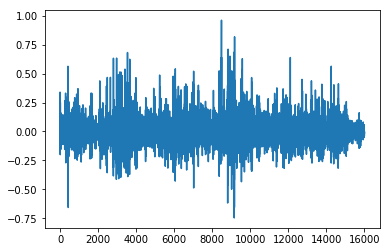

In [130]:
test = deprocess_wav(result.squeeze())
plt.figure()
plt.plot(test)
plt.show()

In [91]:
num_of_row

32.0

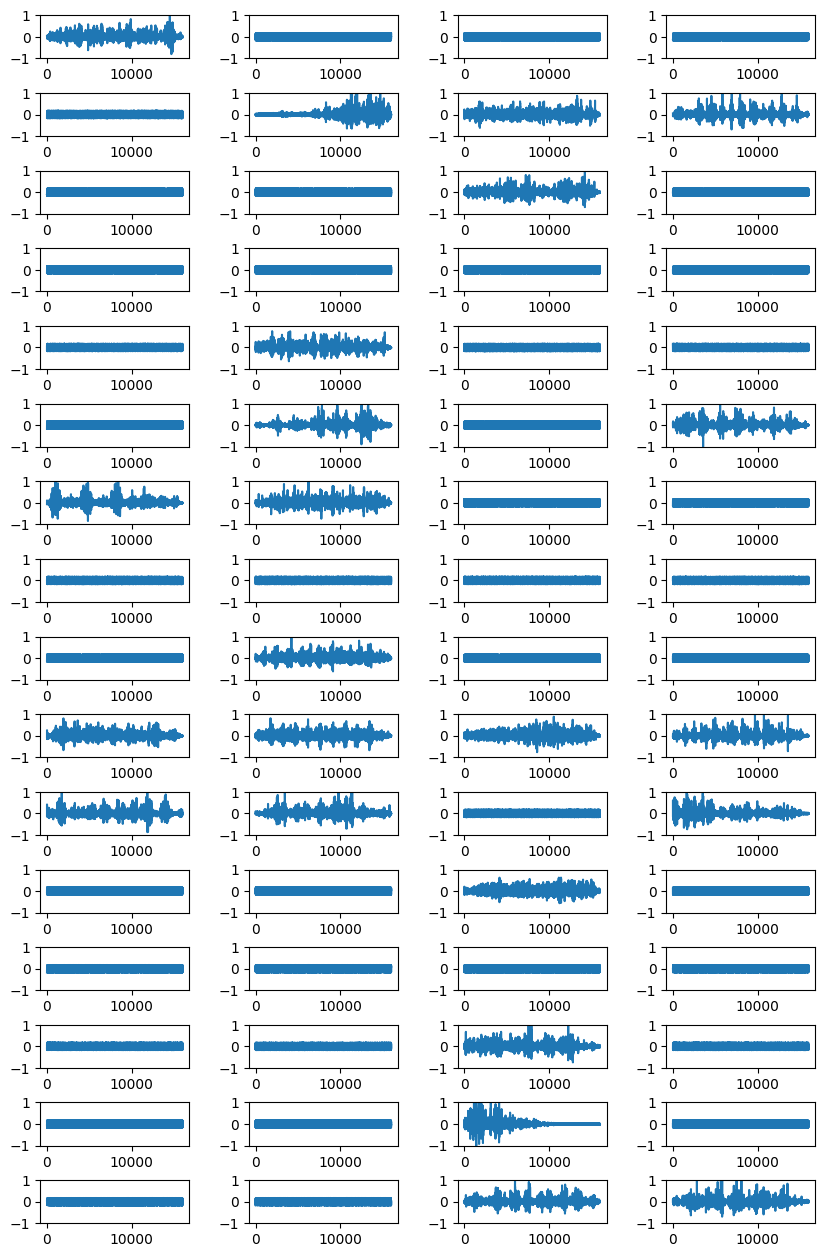

In [145]:
layer_index = 7
num_of_filter = 64

plot_per_row = 4
num_of_row = np.around(num_of_filter/plot_per_row)

fig = plt.figure(figsize=(10, 8*((layer_index//4)+1)), dpi=100)
plt.subplots_adjust(wspace=0.4, hspace=0.8)

# y_min = np.around(activation.min(), decimals=1)
# y_max = np.around(activation.max(), decimals=1)
y_min = -1
y_max = 1

for i in range(num_of_filter):
    plt.subplot(num_of_row, plot_per_row, i+1)
    result = get_activation_maximization(model, layer_index, i)
    result = deprocess_wav(result.squeeze())
#     result = maxabs_scale(result)
    plt.ylim(y_min, y_max)
    plt.plot(result)
plt.show()

In [147]:
import IPython.display as ipd

In [163]:
layer_index = 7
num_of_filter = 64

sr = 16000

output_path = 'maximization_audio/'
os.makedirs(output_path, exist_ok=True)
for i in range(num_of_filter):
    result = get_activation_maximization(model, layer_index, i)
    result_wav = deprocess_wav(result.squeeze())
    librosa.output.write_wav(
        output_path+'{}th_layer_{}th_filter.wav'.format(layer_index, str(i).zfill(3)), result_wav, sr)
#     ipd.Audio(output_path+'{}th_layer_{}th_filter.wav'.format(layer_index, i), rate=sr)

KeyboardInterrupt: 

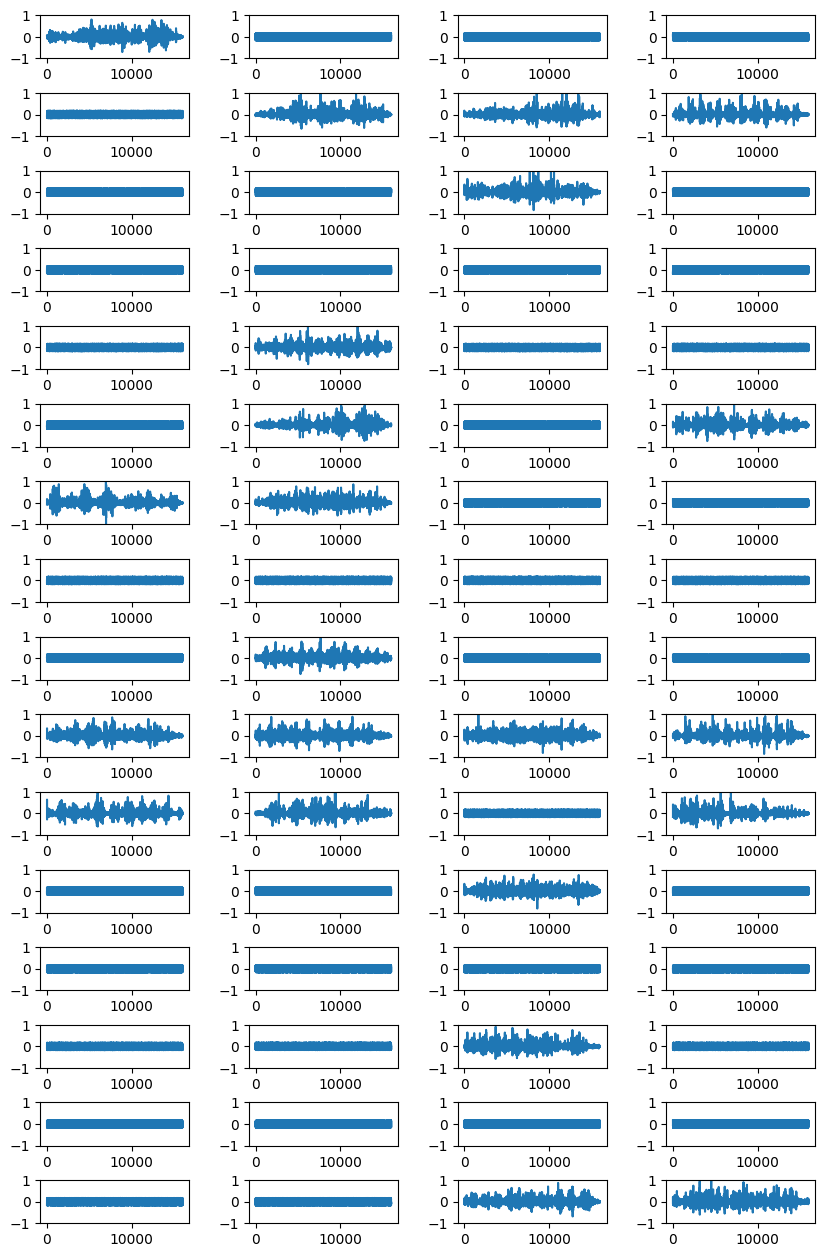

In [167]:
layer_index = 7
num_of_filter = 64

plot_per_row = 4
num_of_row = np.around(num_of_filter/plot_per_row)

fig = plt.figure(figsize=(10, 8*((layer_index//4)+1)), dpi=100)
plt.subplots_adjust(wspace=0.4, hspace=0.8)

# y_min = np.around(activation.min(), decimals=1)
# y_max = np.around(activation.max(), decimals=1)
y_min = -1
y_max = 1

for i in range(num_of_filter):
    plt.subplot(num_of_row, plot_per_row, i+1)
    result = get_activation_maximization(model, layer_index, i)
    result_wav = deprocess_wav(result.squeeze())
#     result = maxabs_scale(result)
    plt.ylim(y_min, y_max)
    plt.plot(result_wav)
    
    librosa.output.write_wav(
    output_path+'{}th_layer_{}th_filter.wav'.format(layer_index, str(i).zfill(3)), result_wav, sr)

plt.show()

In [168]:
!ls 'maximization_audio/'

7th_layer_000th_filter.wav  7th_layer_032th_filter.wav
7th_layer_001th_filter.wav  7th_layer_033th_filter.wav
7th_layer_002th_filter.wav  7th_layer_034th_filter.wav
7th_layer_003th_filter.wav  7th_layer_035th_filter.wav
7th_layer_004th_filter.wav  7th_layer_036th_filter.wav
7th_layer_005th_filter.wav  7th_layer_037th_filter.wav
7th_layer_006th_filter.wav  7th_layer_038th_filter.wav
7th_layer_007th_filter.wav  7th_layer_039th_filter.wav
7th_layer_008th_filter.wav  7th_layer_040th_filter.wav
7th_layer_009th_filter.wav  7th_layer_041th_filter.wav
7th_layer_010th_filter.wav  7th_layer_042th_filter.wav
7th_layer_011th_filter.wav  7th_layer_043th_filter.wav
7th_layer_012th_filter.wav  7th_layer_044th_filter.wav
7th_layer_013th_filter.wav  7th_layer_045th_filter.wav
7th_layer_014th_filter.wav  7th_layer_046th_filter.wav
7th_layer_015th_filter.wav  7th_layer_047th_filter.wav
7th_layer_016th_filter.wav  7th_layer_048th_filter.wav
7th_layer_017th_filter.wav  7th_layer_049th_filter.wav
7th_layer_


--- Layer 1 ---


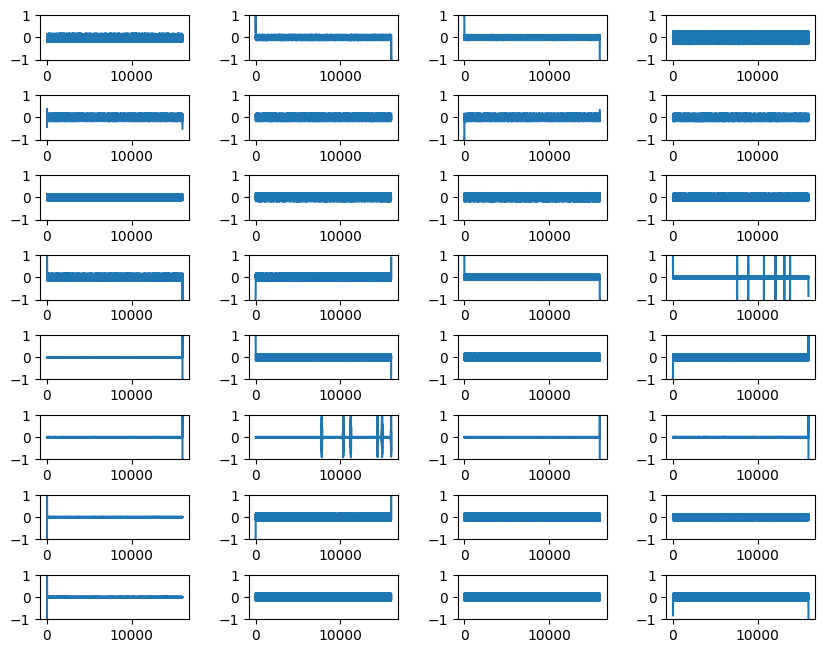


--- Layer 2 ---


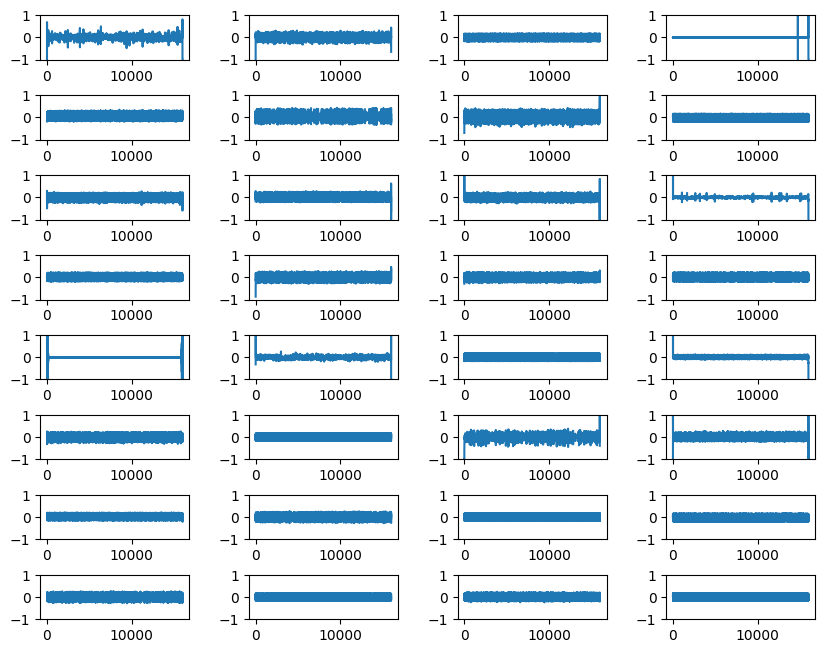


--- Layer 3 ---


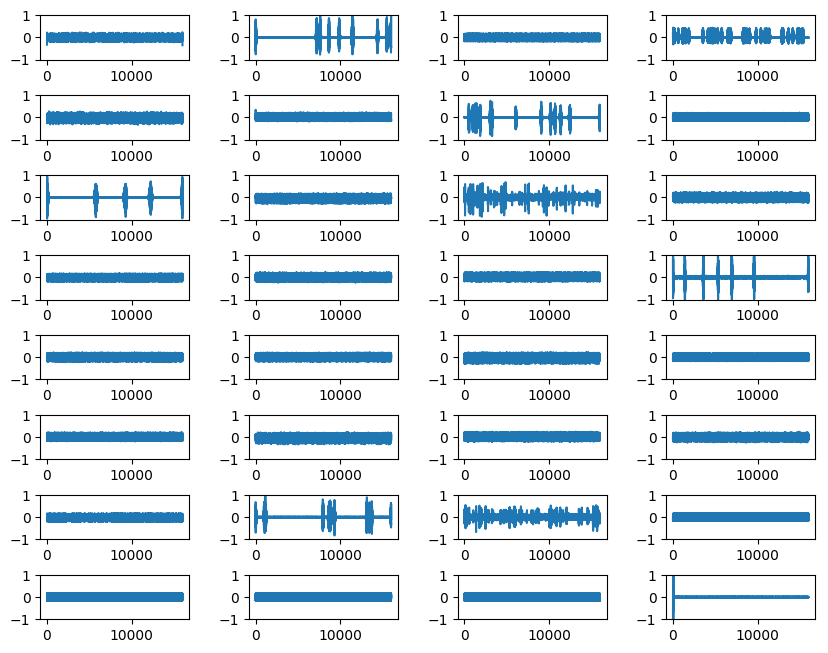


--- Layer 4 ---


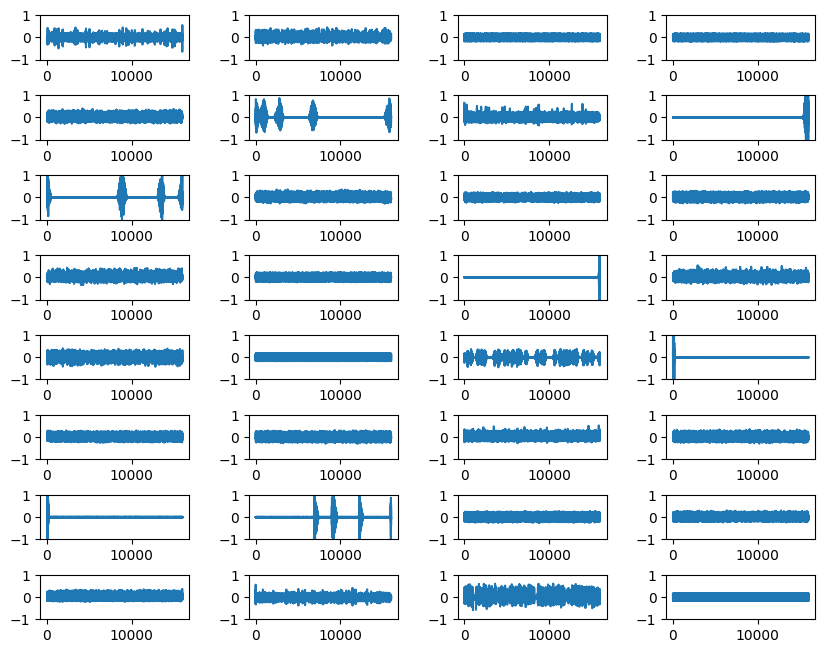


--- Layer 5 ---


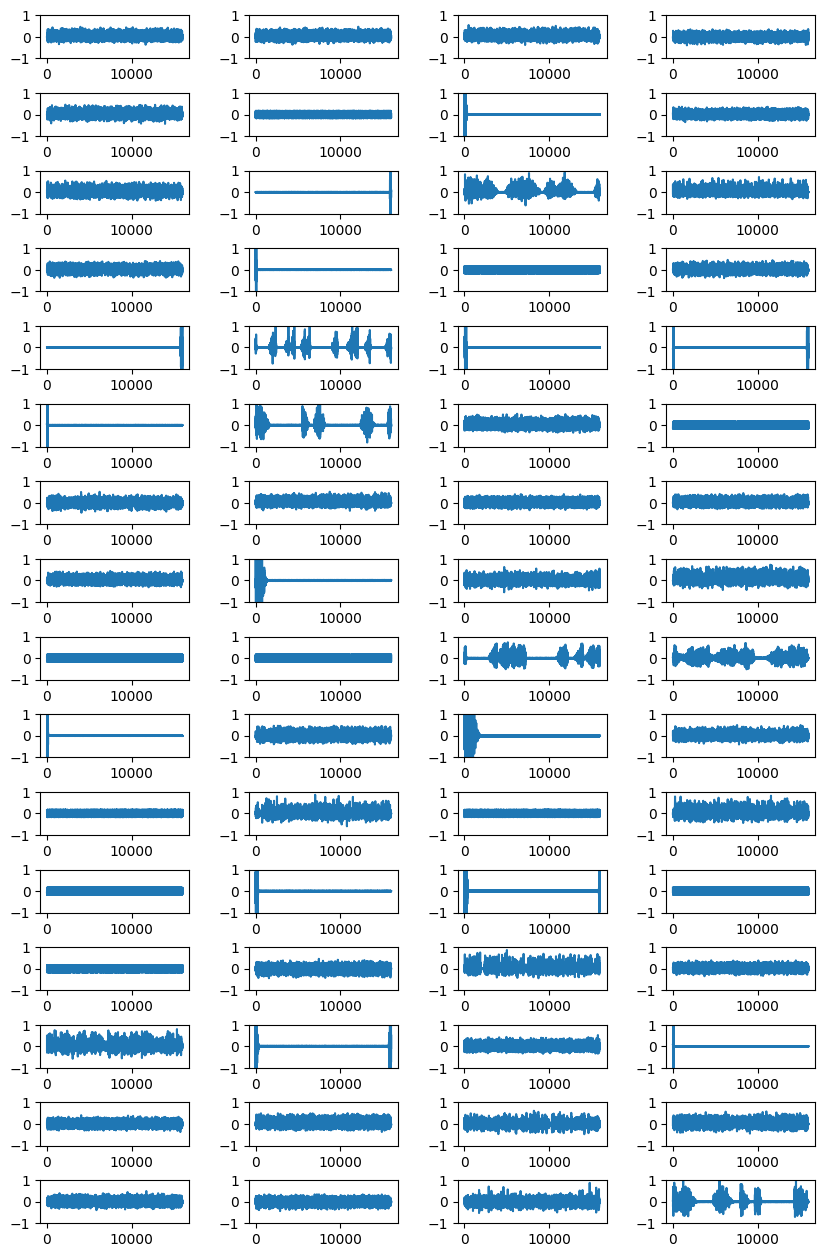


--- Layer 6 ---


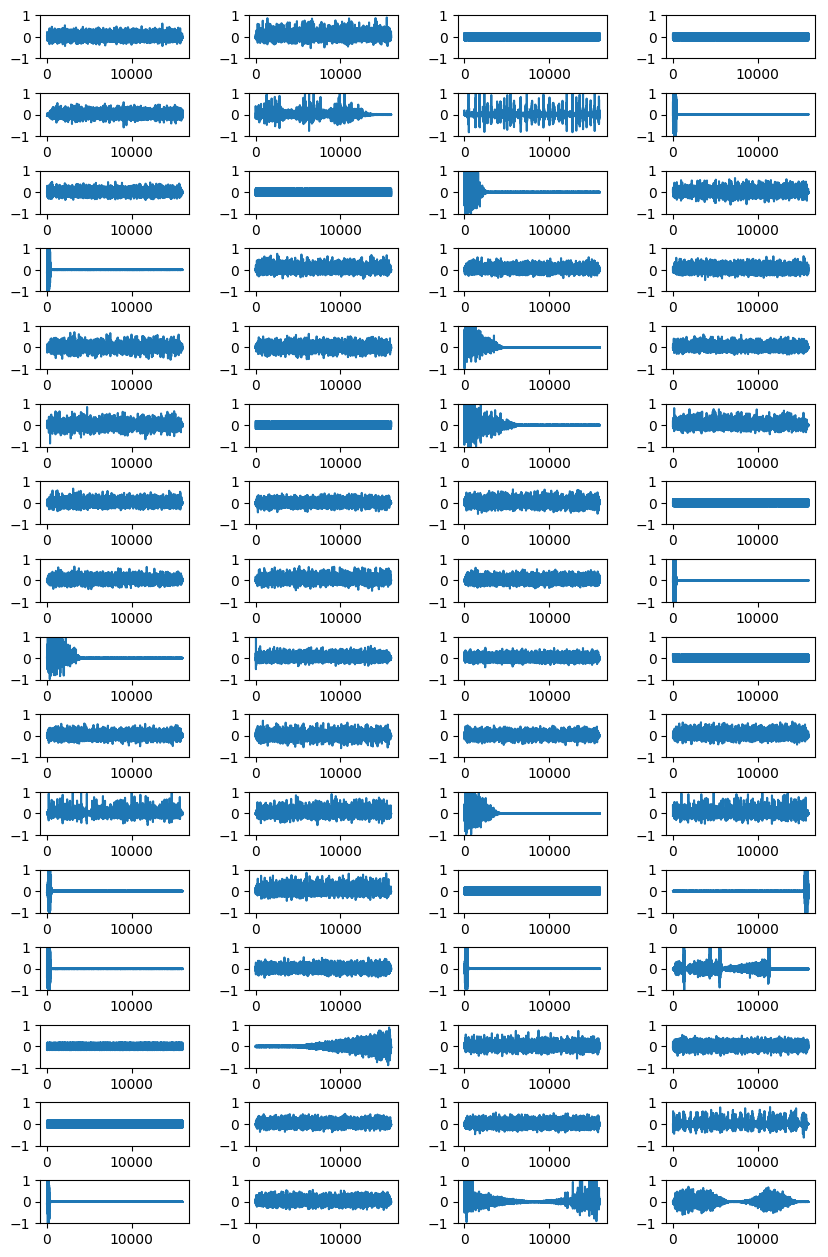


--- Layer 7 ---


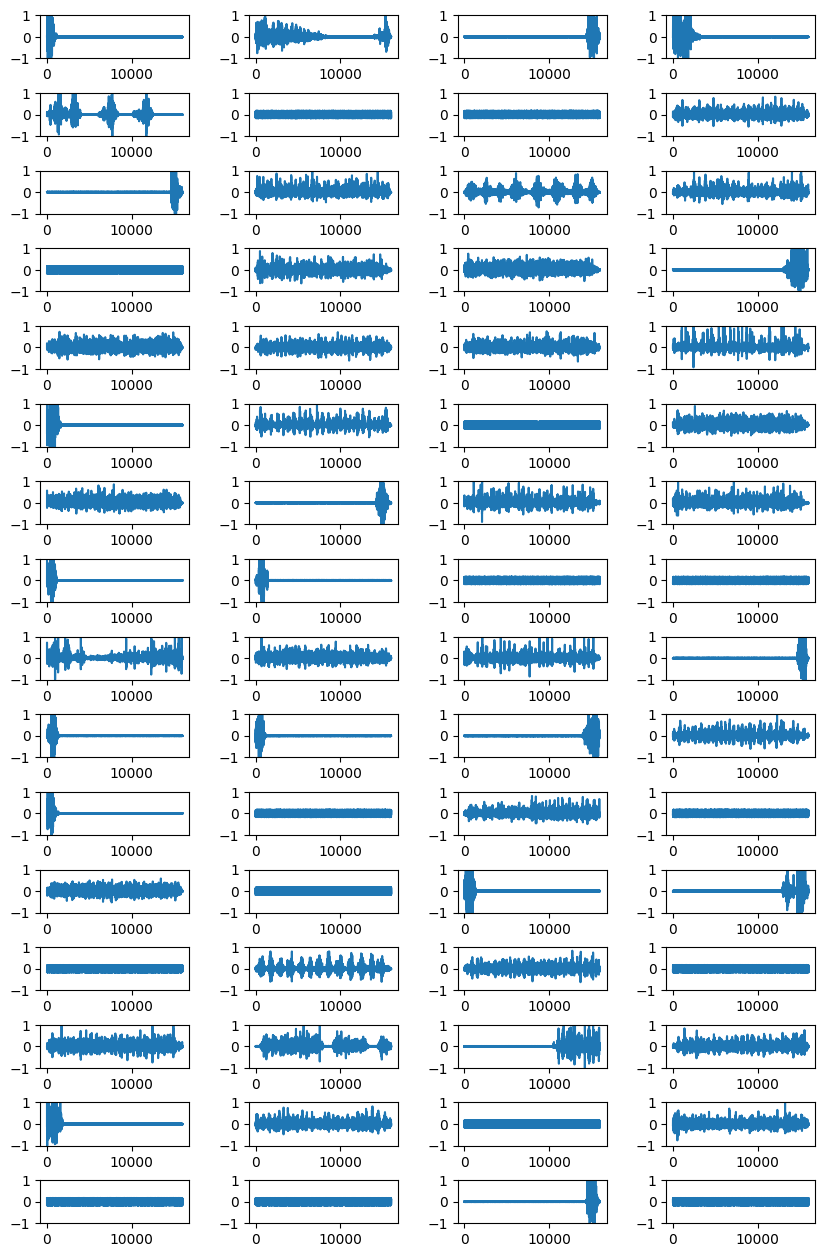


--- Layer 8 ---


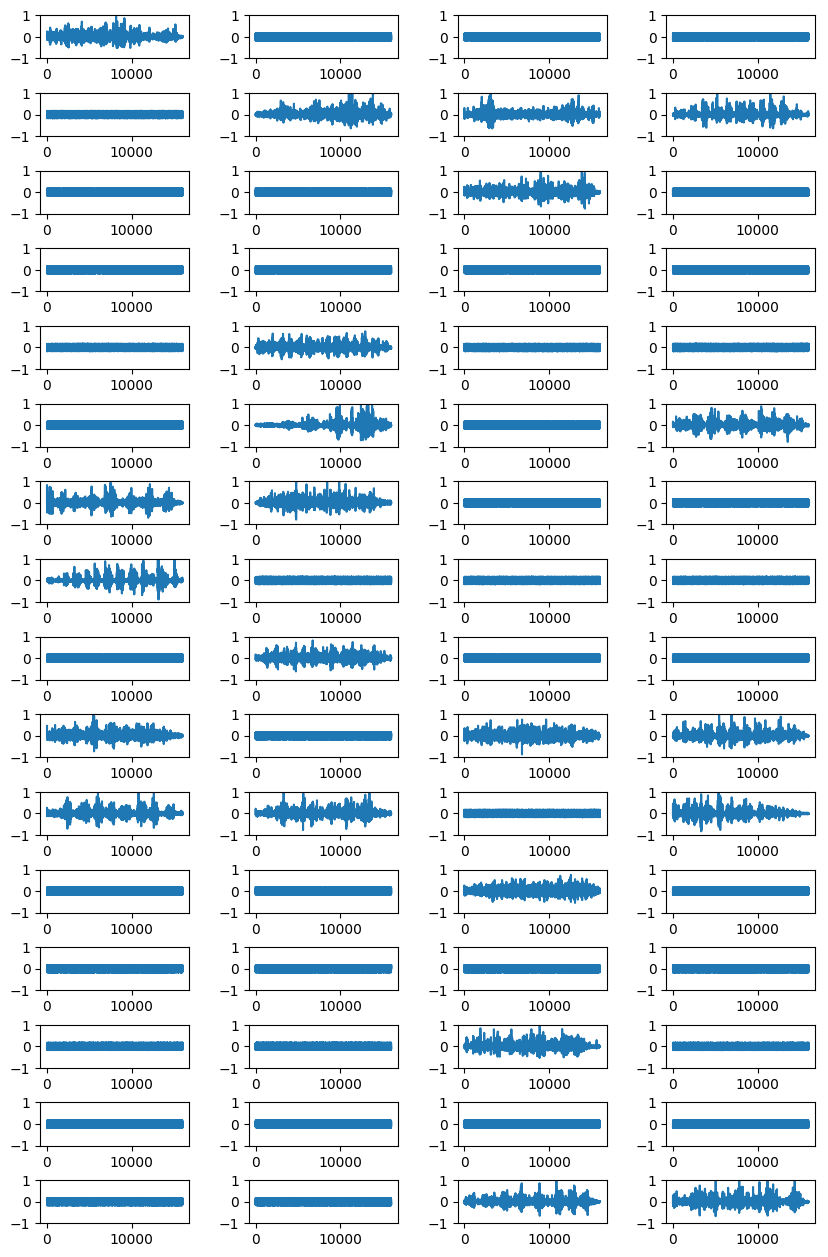

In [10]:
sr = 16000

# y_min = np.around(activation.min(), decimals=1)
# y_max = np.around(activation.max(), decimals=1)
y_min = -1
y_max = 1

output_path = 'maximization_audio/'
os.makedirs(output_path, exist_ok=True)
for layer_index in range(8):
    num_of_filter = 32*(2**int((layer_index)/4))
    
    plot_per_row = 4
    num_of_row = np.around(num_of_filter/plot_per_row)
    
    fig = plt.figure(figsize=(10, 8*((layer_index//4)+1)), dpi=100)
    plt.subplots_adjust(wspace=0.4, hspace=0.8)

    for i in range(num_of_filter):
        plt.subplot(num_of_row, plot_per_row, i+1)
        result = get_activation_maximization(model, layer_index, i)
        result_wav = deprocess_wav(result.squeeze())
    #     result = maxabs_scale(result)
        plt.ylim(y_min, y_max)
        plt.plot(result_wav)

        librosa.output.write_wav(
        output_path+'{}th_layer_{}th_filter.wav'.format(layer_index, str(i).zfill(3)), result_wav, sr)
    
    print()
    print('--- Layer {} ---'.format(layer_index+1))
    plt.show()